In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_rows', 20)


In [2]:
# Definimos las rutas
csv_path = '../input/ar_properties.csv'
pkl_path = '../input/ar_properties.pkl'

# Lógica de carga inteligente
if os.path.exists(pkl_path):
    print(f"🚀 Leyendo desde caché ({pkl_path})...")
    df = pd.read_pickle(pkl_path)
else:
    print(f"🐢 Leyendo desde CSV ({csv_path})... esto puede tardar.")
    df = pd.read_csv(csv_path)
    
    print("💾 Guardando archivo .pkl para la próxima ejecución...")
    df.to_pickle(pkl_path)

print(f"✅ Datos cargados: {df.shape}")

🚀 Leyendo desde caché (../input/ar_properties.pkl)...
✅ Datos cargados: (1000000, 25)


In [3]:
drop_cols = ["id", "title", "description", "end_date", "created_on", "ad_type", "l1", "l4", "l5", "l6", "price_period"]
df = df[df["l1"] == "Argentina"]
df_1 = df.drop(columns=drop_cols)


date_cols = ["start_date"]

for col in date_cols:
    df_1[col] = pd.to_datetime(df[col], errors='coerce', format='%Y-%m-%d')

# Pasamos a tiempo unix
df_1['start_date'] = df_1['start_date'].astype('int64') // 10**9

# Imputasmos lat y lon por la columna l3
df_1['lat'] = df_1['lat'].fillna(df_1.groupby('l3')['lat'].transform('mean'))
df_1['lon'] = df_1['lon'].fillna(df_1.groupby('l3')['lon'].transform('mean'))

# 3. Verificamos cuántos nulos quedan
print("Nulos restantes en lat/lon:")
print(df_1[['lat', 'lon']].isnull().sum())

df_1.drop(columns="l3", inplace=True)


Nulos restantes en lat/lon:
lat    10548
lon    10574
dtype: int64


In [4]:
df_1[["operation_type", "currency"]].value_counts()/ df_1[["operation_type", "currency"]].value_counts().sum()

# El 91% de las operaciones son Venta en USD y Alquiler en ARS, tiramos las columnas que no sean estos dos casos ya que son la minoria

# Definimos la máscara (la condición)
# Fíjate en los paréntesis extra alrededor de cada igualdad ( ) & ( )
condicion_valida = (
    (df_1["operation_type"] == "Venta") & (df_1["currency"] == "USD")
) | (
    (df_1["operation_type"] == "Alquiler") & (df_1["currency"] == "ARS")
)

# Asignamos esa condición directamente a la columna
df_1["is_valid"] = condicion_valida
df_1 = df_1[df_1["is_valid"]]
df_1 = df_1.drop(columns = ["is_valid"])

In [5]:
# Agrupamos categorias minoritarias
min_counts_dict = {
    "l2": 10000,
    "property_type": 110000  
}

# 2. Aplicamos la lógica
for col, min_val in min_counts_dict.items():
    if col in df_1.columns:
        # Calculamos las frecuencias
        counts = df_1[col].value_counts()
        
        # Identificamos las etiquetas que cumplen el criterio
        valid_labels = counts[counts >= min_val].index
        
        # Reemplazamos: Si está en valid_labels, déjalo igual. Si no, pon 'Otros'
        # Usamos .where() de Pandas que es muy rápido
        df_1[col] = df_1[col].where(df_1[col].isin(valid_labels), 'Otros')
        
        print(f"✅ Columna '{col}': Agrupados valores con menos de {min_val} apariciones en 'Otros'.")

# 3. Verificamos el resultado
for col in min_counts_dict.keys():
    print(f"\n--- {col} ---")
    print(df_1[col].value_counts().tail()) # Miramos el final para ver si aparece 'Otros'

✅ Columna 'l2': Agrupados valores con menos de 10000 apariciones en 'Otros'.
✅ Columna 'property_type': Agrupados valores con menos de 110000 apariciones en 'Otros'.

--- l2 ---
l2
Bs.As. G.B.A. Zona Oeste    73780
Santa Fe                    64016
Córdoba                     57875
Otros                       43185
Buenos Aires Interior       21588
Name: count, dtype: int64

--- property_type ---
property_type
Departamento    371948
Otros           305364
Casa            186119
Name: count, dtype: int64


In [8]:
df_1["price"].describe()

count    8.634310e+05
mean     1.933449e+05
std      4.669755e+05
min      0.000000e+00
25%      4.600000e+04
50%      1.000000e+05
75%      2.000000e+05
max      1.111111e+08
Name: price, dtype: float64

# Entrenamiento

# Train-test split

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
# 1. SEPARACIÓN DE VARIABLES (X e y)
# ---------------------------------------------------------

# Definimos columnas a excluir:
# - price: Es lo que queremos predecir
# - start_date: XGBoost no procesa fechas tal cual (ya extrajimos año/mes/dia si hicimos feature engineering)
# - is_valid, price_period: Columnas auxiliares que usamos para filtrar
cols_to_drop = ['price', 'start_date', 'is_valid', 'price_period']

# Opcional: Si filtraste por moneda y tipo operación, son constantes, las borramos
if 'currency' in df_1.columns: cols_to_drop.append('currency')
if 'operation_type' in df_1.columns: cols_to_drop.append('operation_type')

# Definimos X (Features) e y (Target)
X = df_1.drop(columns=cols_to_drop, errors='ignore')
y = df_1['price']

# ---------------------------------------------------------
# 2. CODIFICACIÓN (One-Hot Encoding)
# ---------------------------------------------------------
# XGBoost necesita números. 'get_dummies' convierte columnas como "l3" (Barrio)
# en muchas columnas tipo "l3_Palermo", "l3_Belgrano" con valores 0 o 1.
print("🔄 Codificando variables categóricas...")
X = pd.get_dummies(X, drop_first=True)

# ---------------------------------------------------------
# 3. SPLIT (Train / Test)
# ---------------------------------------------------------
print("✂️ Dividiendo dataset en Train y Test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print("-" * 30)
print(f"✅ Datos listos.")
print(f"Filas de entrenamiento: {X_train.shape[0]}")
print(f"Filas de test:          {X_test.shape[0]}")
print(f"Total de columnas (Features): {X_train.shape[1]}")
print("-" * 30)

🔄 Codificando variables categóricas...
✂️ Dividiendo dataset en Train y Test...
------------------------------
✅ Datos listos.
Filas de entrenamiento: 690744
Filas de test:          172687
Total de columnas (Features): 17
------------------------------


In [ ]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_percentage_error

def objective(trial):
    # Definimos el espacio de búsqueda (Hyperparameters)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        # Fijos
        'n_jobs': -1,
        'random_state': 42,
        'early_stopping_rounds': 50,
        'eval_metric': 'mape' # Usamos MAPE para guiar el early stopping
    }

    # Crear modelo
    model = XGBRegressor(**params)
    
    # Entrenar (usando un set de validación para parar si no mejora)
    model.fit(
        X_train, 
        y_train, 
        eval_set=[(X_test, y_test)], 
        verbose=False
    )
    
    # Predecir y calcular error
    preds = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, preds)
    
    return mape

# Ejecutamos la optimización
print("🧠 Iniciando búsqueda de hiperparámetros...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30) # 30 intentos suele ser suficiente para un buen salto de calidad

print("\n🏆 MEJOR CONFIGURACIÓN:")
print(f"Mejor MAPE: {study.best_value:.2%}")
print("Params:", study.best_params)

[I 2026-02-13 04:18:07,375] A new study created in memory with name: no-name-5f4f9e7b-ecfe-405f-980e-48e8d1bc0571


🧠 Iniciando búsqueda de hiperparámetros...


[I 2026-02-13 04:18:14,528] Trial 0 finished with value: 1.6603897950850586e+17 and parameters: {'n_estimators': 2609, 'max_depth': 4, 'learning_rate': 0.026537639812382642, 'subsample': 0.8859616319245043, 'colsample_bytree': 0.9804657391419248, 'min_child_weight': 3, 'reg_alpha': 6.333505600400481, 'reg_lambda': 4.653712429318499}. Best is trial 0 with value: 1.6603897950850586e+17.
[I 2026-02-13 04:18:22,691] Trial 1 finished with value: 1.666857092083206e+17 and parameters: {'n_estimators': 1771, 'max_depth': 5, 'learning_rate': 0.0050171405555912325, 'subsample': 0.7248729950567128, 'colsample_bytree': 0.9820635234521292, 'min_child_weight': 9, 'reg_alpha': 7.4522469798982724, 'reg_lambda': 5.857849211762432}. Best is trial 0 with value: 1.6603897950850586e+17.
[I 2026-02-13 04:18:39,358] Trial 2 finished with value: 1.6701262984217056e+17 and parameters: {'n_estimators': 2579, 'max_depth': 9, 'learning_rate': 0.006757681186833291, 'subsample': 0.6531061060134276, 'colsample_bytre


🏆 MEJOR CONFIGURACIÓN:
Mejor MAPE: 16481752615993939968.00%
Params: {'n_estimators': 1880, 'max_depth': 3, 'learning_rate': 0.19810535230775575, 'subsample': 0.8369826138733949, 'colsample_bytree': 0.7293981992271709, 'min_child_weight': 7, 'reg_alpha': 5.366912019825583, 'reg_lambda': 7.625201699047308}


## Mejores parametros

✅ Modelo Campeón entrenado.

🔝 Top 10 Variables más importantes:
                       Feature  Importance
4                    bathrooms    0.234843
6              surface_covered    0.159432
11          l2_Capital Federal    0.155012
15  property_type_Departamento    0.134707
3                     bedrooms    0.070362
5                surface_total    0.069292
2                        rooms    0.054383
1                          lon    0.040635
0                          lat    0.037643
16         property_type_Otros    0.014238


/tmp/ipykernel_19030/2824323671.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')


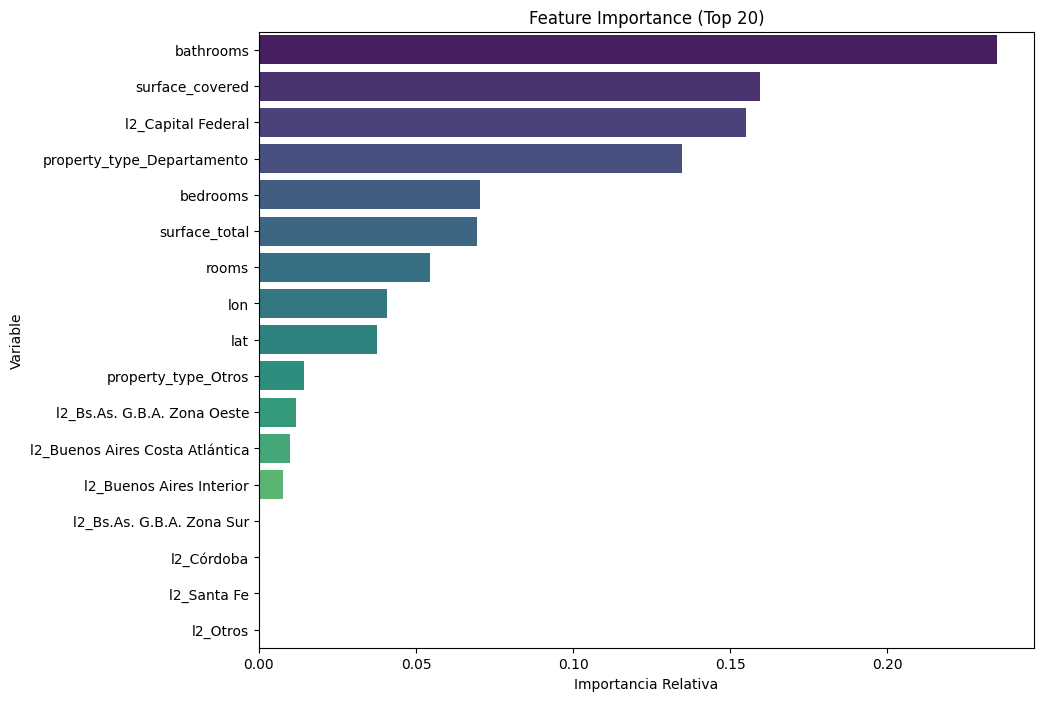

In [ ]:
# 1. Configurar el modelo con los mejores parámetros encontrados
best_params = study.best_params
best_params['n_jobs'] = -1
best_params['random_state'] = 42
best_params['early_stopping_rounds'] = 50
best_params['eval_metric'] = 'mape'

champion_model = XGBRegressor(**best_params)

# 2. Entrenar el modelo final
champion_model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)], 
    verbose=False
)

print("✅ Modelo Campeón entrenado.")

# -------------------------------------------------------
# 3. FEATURE IMPORTANCE (Lo que pediste)
# -------------------------------------------------------

# Opción A: Obtenerlo como DataFrame (para leerlo fácil)
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': champion_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n🔝 Top 10 Variables más importantes:")
print(importance_df.head(10))

# Opción B: Gráfico de Barras (Visual)
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance (Top 20)')
plt.xlabel('Importancia Relativa')
plt.ylabel('Variable')
plt.show()

# Reentrenamos modelo mas simple

In [ ]:
import pandas as pd

N_FEATURES = 9  # <--- CAMBIA ESTE VALOR POR EL QUE QUIERAS (ej: 10, 20, 50)

# 1. Obtener las N columnas más importantes
# Asumimos que 'champion_model' ya está entrenado
df_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': champion_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Seleccionamos las top N
top_features = df_importance.head(N_FEATURES)['Feature'].tolist()

print(f"Las {N_FEATURES} variables elegidas:")
print(top_features)

# 2. Crear los nuevos datasets reducidos (Dinámico)
# Usamos nombres genéricos (_selected) para no romper el código si cambias el número
X_train_selected = X_train[top_features].copy()
X_test_selected = X_test[top_features].copy()

print(f"\nDimensiones nuevas: {X_train_selected.shape} (Originalmente eran {X_train.shape[1]})")

Las 9 variables elegidas:
['bathrooms', 'surface_covered', 'l2_Capital Federal', 'property_type_Departamento', 'bedrooms', 'surface_total', 'rooms', 'lon', 'lat']

Dimensiones nuevas: (690744, 9) (Originalmente eran 17)


In [ ]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

def objective_selected(trial):
    # Definimos el espacio de búsqueda (Hyperparameters)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        # Fijos
        'n_jobs': -1,
        'random_state': 42,
        'early_stopping_rounds': 50,
        'eval_metric': 'mape'
    }

    # Crear modelo usando el dataset GENÉRICO (selected)
    model = XGBRegressor(**params)
    
    # Aquí está el cambio clave: usamos _selected en lugar de _15
    model.fit(
        X_train_selected,  
        y_train, 
        eval_set=[(X_test_selected, y_test)], 
        verbose=False
    )
    
    # Predecir y calcular error
    preds = model.predict(X_test_selected)
    mape = mean_absolute_percentage_error(y_test, preds)
    
    return mape

# Ejecutamos la optimización con los nombres nuevos
print(f"🚀 Iniciando optimización con {X_train_selected.shape[1]} features...")
study_selected = optuna.create_study(direction='minimize')
study_selected.optimize(objective_selected, n_trials=50) 

print("\n🏆 RESULTADO FINAL (DATASET REDUCIDO):")
print(f"Mejor MAPE: {study_selected.best_value:.2%}")
print("Params:", study_selected.best_params)

[I 2026-02-13 04:26:48,479] A new study created in memory with name: no-name-76fbafa2-86b4-4e7c-b8e2-c6095a4a9891


🚀 Iniciando optimización con 9 features...


[I 2026-02-13 04:26:56,724] Trial 0 finished with value: 1.662307746476353e+17 and parameters: {'n_estimators': 1872, 'max_depth': 6, 'learning_rate': 0.06952039714207602, 'subsample': 0.9911023138038015, 'colsample_bytree': 0.9250899390219189, 'min_child_weight': 8, 'reg_alpha': 3.3803524548956942, 'reg_lambda': 2.322606079402507}. Best is trial 0 with value: 1.662307746476353e+17.
[I 2026-02-13 04:27:04,620] Trial 1 finished with value: 1.759455598297109e+17 and parameters: {'n_estimators': 1363, 'max_depth': 7, 'learning_rate': 0.10743673541367944, 'subsample': 0.770983296287732, 'colsample_bytree': 0.8006703968180309, 'min_child_weight': 10, 'reg_alpha': 2.042914383937302, 'reg_lambda': 5.693139217200891}. Best is trial 0 with value: 1.662307746476353e+17.
[I 2026-02-13 04:27:10,428] Trial 2 finished with value: 1.66569369956016e+17 and parameters: {'n_estimators': 1354, 'max_depth': 3, 'learning_rate': 0.017827351041593477, 'subsample': 0.8185042441240998, 'colsample_bytree': 0.84


🏆 RESULTADO FINAL (DATASET REDUCIDO):
Mejor MAPE: 16368399716909801472.00%
Params: {'n_estimators': 638, 'max_depth': 4, 'learning_rate': 0.1893596737117, 'subsample': 0.7699609689873166, 'colsample_bytree': 0.8158326839868605, 'min_child_weight': 1, 'reg_alpha': 5.924026865733517, 'reg_lambda': 8.186689228530337}


In [ ]:
import joblib
from xgboost import XGBRegressor

# 1. Definimos el modelo nuevo 
# Usamos los mejores parámetros que encontró tu Optuna en el paso anterior (Cell 43)
params = {
    'n_estimators': 638,
    'max_depth': 4,
    'learning_rate': 0.189,
    'subsample': 0.77,
    'colsample_bytree': 0.81,
    'min_child_weight': 1,
    'reg_alpha': 5.92,
    'reg_lambda': 8.18,
    'n_jobs': -1,
    'random_state': 42,
    'early_stopping_rounds': 50,
    'eval_metric': 'mape'
}

final_model = XGBRegressor(**params)

# 2. ENTRENAMIENTO CRÍTICO ⚠️
# Aquí es donde ocurre la magia: Usamos X_train_selected (Solo las 9 columnas)
print(f"📉 Entrenando modelo reducido con {X_train_selected.shape[1]} columnas...")

final_model.fit(
    X_train_selected, 
    y_train, 
    eval_set=[(X_test_selected, y_test)], 
    verbose=False
)

# 3. Guardar el artefacto correcto
# Ahora sí: El modelo espera 9 columnas y la lista tiene 9 columnas. MATCH.
artifact = {
    "model": final_model,              
    "features": X_train_selected.columns.tolist() 
}

joblib.dump(artifact, 'xgb_price_predictor_v1.joblib')

print("✅ Modelo re-entrenado y guardado correctamente.")
print("   Ahora sí puedes correr el bloque de predicción.")

📉 Entrenando modelo reducido con 9 columnas...
✅ Modelo re-entrenado y guardado correctamente.
   Ahora sí puedes correr el bloque de predicción.


## Prueba API

In [ ]:
import pandas as pd
import joblib

# 1. CARGAR EL MODELO Y LAS COLUMNAS
# ---------------------------------------------------------
print("📂 Cargando modelo...")
artifact = joblib.load('xgb_price_predictor_v1.joblib')
model = artifact["model"]
model_features = artifact["features"] 

# 2. INPUT DEL USUARIO
# ---------------------------------------------------------
input_data = {
    "lat": -34.6037,
    "lon": -58.3816,
    "l2": "Capital Federal",     
    "property_type": "Departamento", 
    "rooms": 2,
    "surface_total": 60,
    "surface_covered": 55,
    "bedrooms": 1,
    "bathrooms": 1
}

# 3. PROCESAMIENTO (TU LÓGICA DE PRODUCCIÓN)
# ---------------------------------------------------------
# A. Crear DataFrame
df = pd.DataFrame([input_data])

# B. One-Hot Encoding
df_encoded = pd.get_dummies(df)

# C. Alineación (El paso clave)
# Rellena con 0 las columnas que faltan (ej: l2_Capital Federal)
# Borra las que sobran
df_final = df_encoded.reindex(columns=model_features, fill_value=0)

# 4. PREDICCIÓN FINAL 🚀
# ---------------------------------------------------------
print("🔮 Calculando precio...")
prediction_array = model.predict(df_final)
precio_estimado = prediction_array[0] # Sacamos el valor del array

print("-" * 30)
print(f"🏠 Propiedad: {input_data['property_type']} en {input_data['l2']}")
print(f"📏 Superficie: {input_data['surface_total']} m2")
print(f"💰 PRECIO PREDICHO: USD {precio_estimado:,.2f}")
print("-" * 30)

📂 Cargando modelo...
🔮 Calculando precio...
------------------------------
🏠 Propiedad: Departamento en Capital Federal
📏 Superficie: 60 m2
💰 PRECIO PREDICHO: USD 172,449.47
------------------------------
